In [1]:
#Installs Needed
#!pip install opencv-python
#!pip install pillow
#os.getcwd()

In [2]:
import os
import concurrent.futures
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from tensorflow.keras.utils import to_categorical
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Sequential, load_model
from keras.metrics import Precision, Recall, AUC

print("Booting...")

Booting...


In [3]:
# Path to Image Folder
image_folder = "semantic_drone_dataset/training_set/images"
image_label_folder = "semantic_drone_dataset/training_set/gt/semantic/label_images"
csv_file_path = 'semantic_drone_dataset/training_set/gt/semantic/class_dict.csv'

images = []
label_images = []

target_size = (600, 400)  # Resize OG Image Size: (6000,1000)

In [4]:
def load_and_process_image(filename, folder, file_extension):
    if filename.lower().endswith(file_extension):  # Check if the file has the correct extension
        image_path = os.path.join(folder, filename)
        with Image.open(image_path) as image:
            resized_image = image.resize(target_size, Image.NEAREST)
            return np.array(resized_image)
    else:
        return None  

In [5]:
# Function to load images using multiple threads
def load_images_concurrently(folder_path, file_extension):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        all_files = os.listdir(folder_path)

        processed_images = list(executor.map(load_and_process_image, all_files, [folder_path]*len(all_files), [file_extension]*len(all_files)))

        return [image for image in processed_images if image is not None]

# Load images using threads
images = load_images_concurrently(image_folder, '.jpg')

# Load label images using threads
label_images = load_images_concurrently(image_label_folder, '.png')

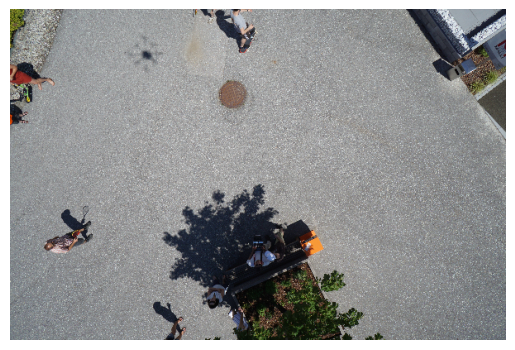

Image size: (400, 600, 3)


In [6]:
# Display the first image
if images:
    plt.imshow(images[0])
    plt.axis('off')  # Remove axis labels
    plt.show()
    
    # Print the size of the image
    image_size = images[0].shape
    print("Image size:", image_size)

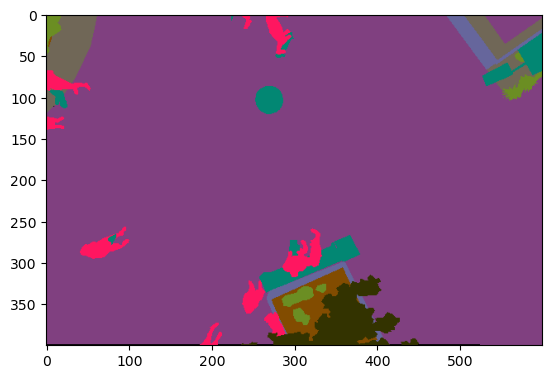

Image size: (400, 600, 3)


In [7]:
# Display the first label image
if label_images:
    plt.imshow(label_images[0])
    plt.show()
    
    # Print the size of the image
    image_size = label_images[0].shape
    print("Image size:", image_size)

In [8]:
# Load class definitions from the class_dict.csv
class_df = pd.read_csv(csv_file_path, index_col=False, skipinitialspace=True)

# Map class names to RGB values
class_dict = {tuple(row[['r', 'g', 'b']].values): row['name'] for _, row in class_df.iterrows()}

# Extract label codes and names
label_codes = [tuple(row[['r', 'g', 'b']].values) for _, row in class_df.iterrows()]
label_names = [class_dict.get(rgb, 'Unknown') for rgb in label_codes]
length_of_label_codes = len(label_codes)
print(length_of_label_codes)

24


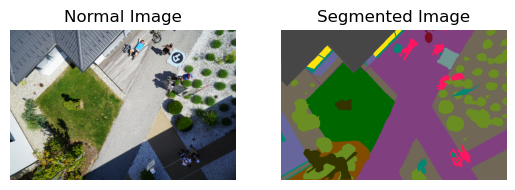

In [9]:
#Pre-process Data
normal_images = []
segmented_images = []
num_classes = length_of_label_codes;
num_images_to_process = 500
input_shape_var = (400, 600, 3)

normal_images = np.array(images[:num_images_to_process])
segmented_images = np.array(label_images[:num_images_to_process])

# Split the data into training and validation sets
split_ratio = 0.8
split = int(split_ratio * len(normal_images))

train_images, test_images = normal_images[:split], normal_images[split:]
train_labels, test_labels = segmented_images[:split], segmented_images[split:]

# Randomly select and visualize one pair of images
random_index = np.random.randint(len(train_images))

x = train_images[random_index]
y = train_labels[random_index]

# Plot the normal image
plt.subplot(1, 2, 1)
plt.imshow(x)
plt.title("Normal Image")
plt.axis("off")

# Plot the segmented image
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.title("Segmented Image")
plt.axis("off")

plt.show()

In [10]:
# Create a mapping from RGB values to integer identifiers
rgb_to_id_mapping = {tuple(code): i for i, code in enumerate(label_codes)}

# Print the mapping for verification
print("RGB to ID Mapping:", rgb_to_id_mapping)

# Convert RGB images to integer labels
train_labels_int = np.zeros_like(train_labels[:, :, :, 0], dtype=np.uint8)
test_labels_int = np.zeros_like(test_labels[:, :, :, 0], dtype=np.uint8)

for i in range(num_classes):
    mask_train = np.all(train_labels == label_codes[i], axis=-1)
    mask_test = np.all(test_labels == label_codes[i], axis=-1)

    train_labels_int[mask_train] = i
    test_labels_int[mask_test] = i

# Apply one-hot encoding
train_labels_one_hot = np.eye(num_classes)[train_labels_int]
test_labels_one_hot = np.eye(num_classes)[test_labels_int]

# Print the shape of the one-hot encoded labels
print("Shape of one-hot encoded train labels:", train_labels_one_hot.shape)
# Print the shape of the one-hot encoded labels
print("Shape of one-hot encoded test labels:", test_labels_one_hot.shape)

# Print a small portion of the one-hot encoded labels for verification
#print("One-Hot Encoded Labels (a small portion):")
#print(train_labels_one_hot[:5, :5, :])

RGB to ID Mapping: {(0, 0, 0): 0, (128, 64, 128): 1, (130, 76, 0): 2, (0, 102, 0): 3, (112, 103, 87): 4, (28, 42, 168): 5, (48, 41, 30): 6, (0, 50, 89): 7, (107, 142, 35): 8, (70, 70, 70): 9, (102, 102, 156): 10, (254, 228, 12): 11, (254, 148, 12): 12, (190, 153, 153): 13, (153, 153, 153): 14, (255, 22, 96): 15, (102, 51, 0): 16, (9, 143, 150): 17, (119, 11, 32): 18, (51, 51, 0): 19, (190, 250, 190): 20, (112, 150, 146): 21, (2, 135, 115): 22, (255, 0, 0): 23}
Shape of one-hot encoded train labels: (320, 400, 600, 24)
Shape of one-hot encoded test labels: (80, 400, 600, 24)


In [11]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_var, padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),
    Dropout(0.25), 
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),
    Dropout(0.25), 
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(num_classes, (3, 3), activation='softmax', padding='same')
])


model.summary()

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels_one_hot.shape)
print("Validation images shape:", test_images.shape)
print("Validation labels shape:", test_labels_one_hot.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 600, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 400, 600, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 400, 600, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 400, 600, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 200, 300, 64)      0         
 D)                                                              
                                                        

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [14]:
class_weights = {0: 1.0, 1: 0.9, 2: 1.0, 3: 0.9, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 5.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0}

batch_size = 1
num_epochs = 10

train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=batch_size)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with class weights using the generator
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=(test_images, test_labels_one_hot),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/10
320/320 [==============================] - 901s 3s/step - loss: 2.5232 - accuracy: 0.3221 - precision: 0.2367 - recall: 0.0029 - auc: 0.8165 - val_loss: 223.6482 - val_accuracy: 0.0731 - val_precision: 0.0728 - val_recall: 0.0728 - val_auc: 0.0636
Epoch 2/10
320/320 [==============================] - 891s 3s/step - loss: 2.2320 - accuracy: 0.3579 - precision: 0.2963 - recall: 0.0071 - auc: 0.8714 - val_loss: 3373.5007 - val_accuracy: 0.0394 - val_precision: 0.0394 - val_recall: 0.0394 - val_auc: 0.0601
Epoch 3/10
320/320 [==============================] - 900s 3s/step - loss: 2.2283 - accuracy: 0.3621 - precision: 0.3008 - recall: 0.0053 - auc: 0.8720 - val_loss: 244.3155 - val_accuracy: 0.2084 - val_precision: 0.2085 - val_recall: 0.2083 - val_auc: 0.0727


In [15]:
# You can save the model if needed
model.save('semantic_segmentation_model.h5')

C:\AnacondaApp\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# Evaluate on test data || Throws Errors Occasionally
predictions = model.predict(test_images)

# Convert predictions and ground truth to integer labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(test_labels_one_hot, axis=-1)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(true_labels.flatten(), predicted_labels.flatten(), average=None, zero_division=1)
recall = recall_score(true_labels.flatten(), predicted_labels.flatten(), average=None, zero_division=1)
f1 = f1_score(true_labels.flatten(), predicted_labels.flatten(), average=None, zero_division=1)

# Print metrics for each class
num_classes = np.max(true_labels) + 1  
for i in range(num_classes):
    if i < len(precision) and i < len(recall) and i < len(f1):
        print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}")
    else:
        print(f"Class {i} - Precision: N/A, Recall: N/A, F1 Score: N/A")

print("Training History:", history.history)

3/3 [==============================] - 29s 8s/step
Class 0 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 1 - Precision: 0.15159944367176634, Recall: 2.8513195135021097e-05, F1 Score: 5.701566662364338e-05
Class 2 - Precision: 0.03514342952133328, Recall: 0.0032829574887863807, F1 Score: 0.006004956182756052
Class 3 - Precision: 0.1737417386883579, Recall: 0.0006823435981869726, F1 Score: 0.0013593485667548783
Class 4 - Precision: 0.0958904109589041, Recall: 4.793243444041279e-06, F1 Score: 9.58600771536678e-06
Class 5 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 6 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 7 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 8 - Precision: 0.07284488088876595, Recall: 0.9017822271073717, F1 Score: 0.13480072200393364
Class 9 - Precision: 0.08202427374791099, Recall: 0.1006709791396655, F1 Score: 0.0903960428189503
Class 10 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 11 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 12 - Pr

1/1 [==============================] - 0s 395ms/step


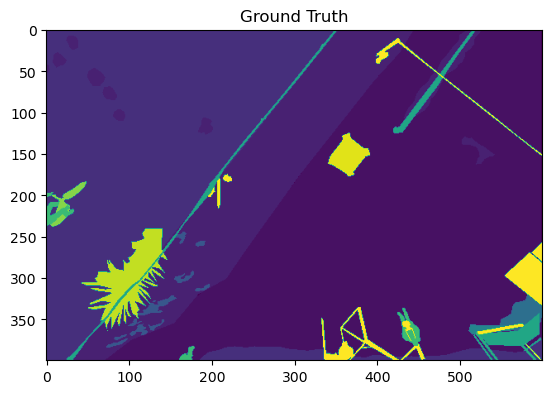

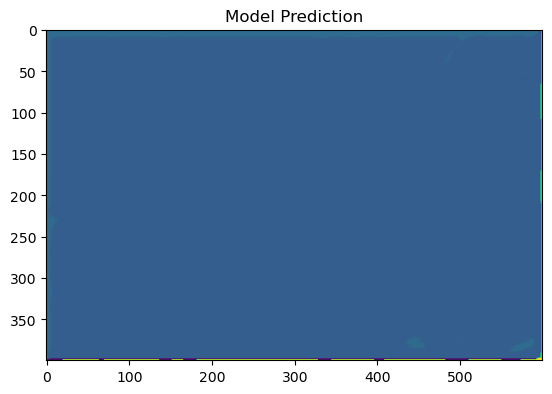

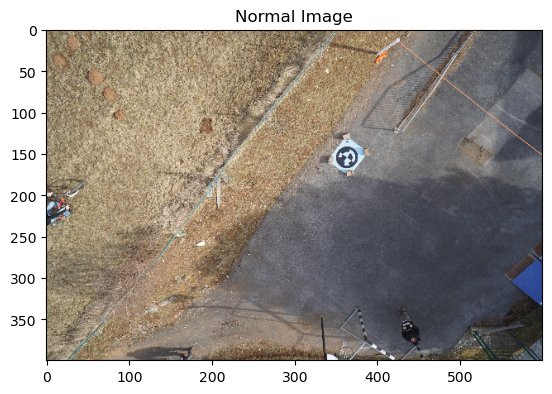

In [17]:
# Choose a random sample index for visualization
sample_index = np.random.randint(0, len(train_images))

# Get the model's prediction on the chosen image
prediction = model.predict(np.expand_dims(train_images[sample_index], axis=0))

# Visualize the original segmented image (Ground Truth)
plt.imshow(np.argmax(train_labels_one_hot[sample_index], axis=-1), cmap='viridis')
plt.title("Ground Truth")
plt.show()

# Visualize the model's prediction
plt.imshow(np.argmax(prediction[0], axis=-1), cmap='viridis')
plt.title("Model Prediction")
plt.show()

# Visualize the normal image
plt.imshow(train_images[sample_index])
plt.title("Normal Image")
plt.show()


In [18]:
print("Finished")

Finished
